In [149]:
from CentralStreamingModel.utils.read_probabilities import VD_los
from CentralStreamingModel.skewt import skewt as st
from CentralStreamingModel.skewt import skewt_moments
from scipy.integrate import simps
import numpy as np
import matplotlib.pyplot as plt
from CentralStreamingModel.integral import real2redshift as real2red
import os, glob
import pickle
from scipy.stats import norm
from scipy.optimize import curve_fit
from halotools.mock_observables import tpcf_multipole
import seaborn as sns
from scipy.misc import derivative
from scipy.interpolate import UnivariateSpline
sns.set_context('talk')

In [2]:
import importlib
importlib.reload(st)

<module 'CentralStreamingModel.skewt.skewt' from '/home/c-cuesta/CentralStreamingModel/skewt/skewt.py'>

In [3]:
n_boxes = range(1,14)
boxsize = 2000
snapshot = 11

central_halos = []
for i, box in enumerate(n_boxes):
    central_halos.append(VD_los('halos', box, boxsize, snapshot,extra = 'r2'))

In [4]:
# Get mean los PDF
central_halos_pdf = [halo.jointpdf for halo in central_halos]

mean_los_pdf = np.mean(central_halos_pdf, axis=0)
std_los_pdf = np.std(central_halos_pdf, axis=0)

In [5]:
# Get mean real and redshift TPCF
data_dir = '/raid/c-cuesta/tpcfs/'

# Load real space tpcf
list_dictionaries = []
os.chdir(data_dir + 'real/')
for real_tpcf in glob.glob(f"*_s{snapshot:03d}.pickle"):
    with open(real_tpcf, "rb") as input_file:
        list_dictionaries.append(pickle.load(input_file))
tpcfs = [dictionary['tpcf'] for dictionary in list_dictionaries]
mean_tpcf = np.mean(tpcfs, axis=0)
std_tpcf = np.std(tpcfs, axis=0)

mean_tpcf_dict =  {'r': list_dictionaries[0]['r'], 'tpcf': mean_tpcf}   

In [6]:
# Load reshift space tpcf
list_dictionaries = []
os.chdir(data_dir + 'redshift/')
for real_tpcf in glob.glob(f"box???_s{snapshot:03d}.pickle"):
    with open(real_tpcf, "rb") as input_file:
        list_dictionaries.append(pickle.load(input_file))

In [7]:
monopoles = [dictionary['mono'] for dictionary in list_dictionaries]
mean_mono = np.mean(monopoles, axis=0)
std_mono = np.std(monopoles, axis=0)

quadrupoles = [dictionary['quad'] for dictionary in list_dictionaries]
mean_quad = np.mean(quadrupoles, axis=0)
std_quad = np.std(quadrupoles, axis=0)

hexadecapoles = [dictionary['hexa'] for dictionary in list_dictionaries]
mean_hexa = np.mean(hexadecapoles, axis=0)
std_hexa = np.std(hexadecapoles, axis=0)

In [66]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)

## Streaming Model

In [9]:
rparallel, integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, mean_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

## Gaussian/ST Streaming Model

In [10]:
def gaussian(v, mean, std):
    return norm.pdf(v, loc = mean, scale = std)

In [11]:
gaussian_los_pdf = np.zeros_like(mean_los_pdf)
bf_gaussian_los_pdf = np.zeros_like(mean_los_pdf)

st_los_pdf = np.zeros_like(mean_los_pdf)
bf_st_los_pdf = np.zeros_like(mean_los_pdf)

vlos = central_halos[0].v

for i, rperp in enumerate(central_halos[0].r.t):
    for j, rpar in enumerate(central_halos[0].r.r):
        
        # Measure moments
        mean = simps(mean_los_pdf[i,j] * vlos, vlos)
        std = np.sqrt(simps(mean_los_pdf[i,j] * (vlos - mean)**2, vlos))
        gamma1 = simps(mean_los_pdf[i,j] * (vlos - mean)**3, vlos)/std**3
        gamma2 = simps(mean_los_pdf[i,j] * (vlos - mean)**4, vlos)/std**4 - 3.
        
        gaussian_los_pdf[i, j, :] = norm.pdf(vlos, loc = mean, scale = std)
        
        # Moments to ST parameters
        
        v_c, w, alpha, nu = skewt_moments.moments2parameters(mean, std, gamma1, gamma2)
        
        st_los_pdf[i,j,:] = st.skewt_pdf(vlos, w, v_c, alpha, nu)
        
        
        popt, pcov = curve_fit(gaussian, vlos, mean_los_pdf[i,j,:]) 
        
        bf_gaussian_los_pdf[i,j,:] = norm.pdf(vlos, loc = popt[0], scale = popt[1])
        
        popt, pcov = curve_fit(st.skewt_pdf, vlos, 
                                    mean_los_pdf[i,j,:],
                                     p0 = [ 5.,  2.,-0.2, 30.])
        
        bf_st_los_pdf[i,j,:] = st.skewt_pdf(vlos,
                                   *popt)

/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5204: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5204: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


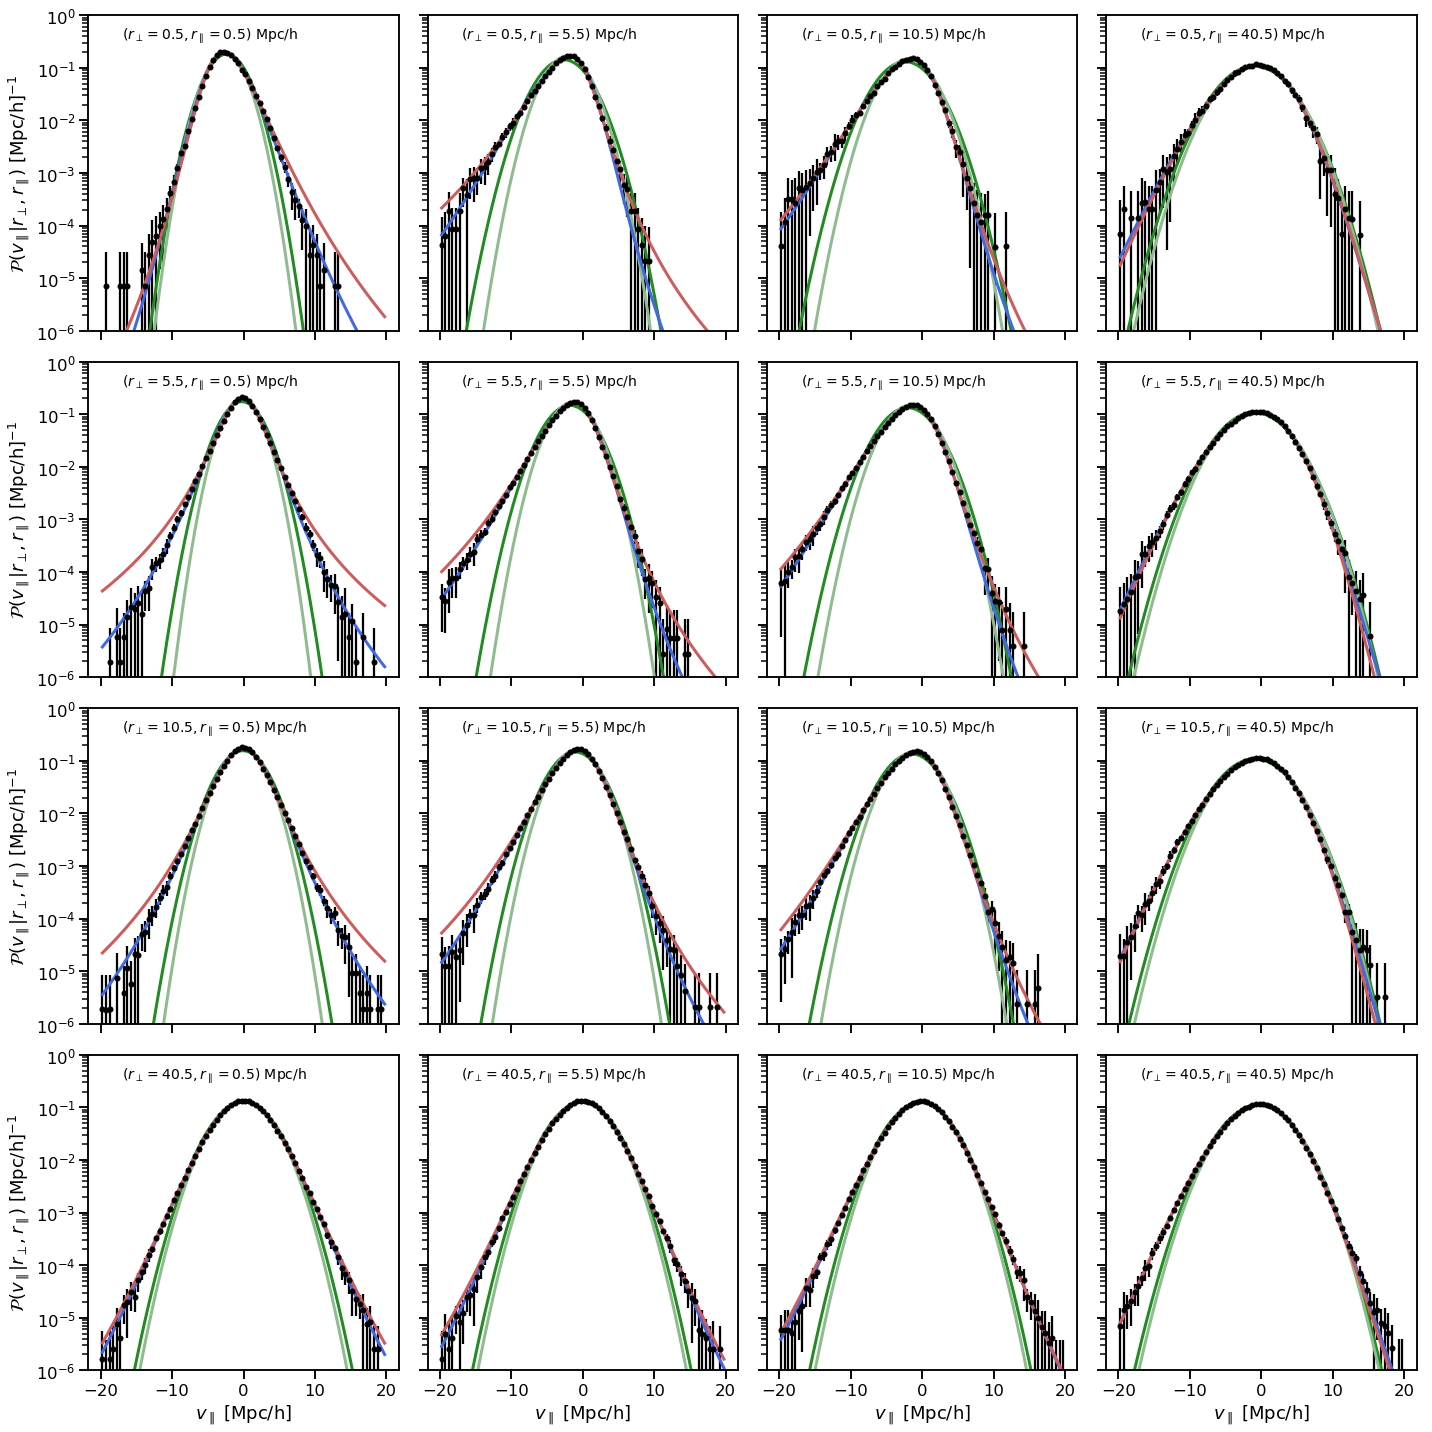

In [12]:
rlist1 = [0,5,10,40]
rlist2 = [0,5,10,40]

fig, axes = plt.subplots(nrows=len(rlist2),
                         ncols=len(rlist1),sharex=True,
                         sharey=True, figsize=(20,20))

for i, rperp in enumerate(rlist2):
    for j, rparal in enumerate(rlist1):
        axes[i,j].text(-17,3.5e-1,r'($ r_\perp = %.1f'
                       ', r_\parallel = %.1f)$ Mpc/h'%(central_halos[0].r.t[rperp],
                                                       central_halos[0].r.t[rparal]),fontsize=14)
        axes[i,j].errorbar(central_halos[0].v, mean_los_pdf[rperp,rparal], 
                yerr = std_los_pdf[rperp,rparal],
                linestyle='', marker='o',
                markersize = 5, color='k', label='Measured')
        
        axes[i,j].plot(central_halos[0].v, gaussian_los_pdf[rperp,rparal], 
                linestyle='-',color='forestgreen', label='Gaussian', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, bf_gaussian_los_pdf[rperp,rparal], 
                linestyle='-',color='darkseagreen', label='Gaussian - BF', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, st_los_pdf[rperp,rparal], 
                linestyle='-',  color='royalblue', label='ST', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, bf_st_los_pdf[rperp,rparal], 
                linestyle='-',  color='indianred', label='ST - BF', linewidth=3)

        axes[i,j].set_yscale("log", nonposy='clip')

        axes[i,j].set_ylim(1e-6,0.99)
        if j == 0:
            axes[i,j].set_ylabel(r'$\mathcal{P}(v_\parallel | r_\perp, r_\parallel)$ [Mpc/h]$^{-1}$')
            labels = list(axes[i,j].get_yticklabels())
            labels[-1] = ''
            axes[i,j].set_yticklabels(labels)
            
        if i == len(rlist2)-1:
            axes[i,j].set_xlabel(r'$v_\parallel$ [Mpc/h]')
            
        #if i==len(rlist2)-1 and j==0:
        #    axes[i,j].legend()
            
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
#plt.savefig(plots_dir + 'los.pdf', dpi=240)

## ST Streaming Model

In [13]:
rparallel, gaussian_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, gaussian_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [14]:
rparallel, bf_gaussian_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, bf_gaussian_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [15]:
rparallel, st_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, st_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [16]:
rparallel, bf_st_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, bf_st_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [17]:
from scipy.interpolate import interp1d, interp2d

In [18]:
interp_twopcf = interp1d(mean_tpcf_dict['r'], mean_tpcf_dict['tpcf'], kind = 'cubic',                                             
    fill_value = (-1., mean_tpcf_dict['tpcf'][-1]), bounds_error=False)   

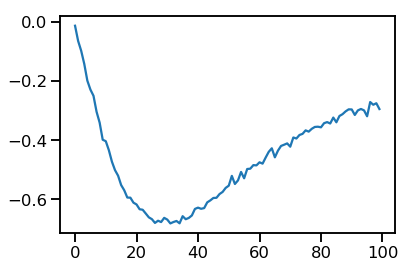

In [177]:
plt.plot(simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1))

Text(0, 0.5, '$\\frac{d \\mu}{d s_\\parallel}$')

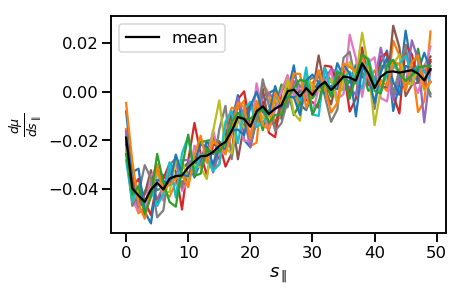

In [175]:
derivative_ind = []
sperp = 30
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1)
    m1_interp = interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False)
    #plt.plot(m1_interp(central_halos[0].r.r))
    #plt.plot(m1, linestyle='', marker='o', markersize=2)
    #plt.show()

    plt.plot(derivative(m1_interp, central_halos[0].r.t))
    derivative_ind.append(derivative(m1_interp, central_halos[0].r.t))
    
derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d \mu}{d s_\parallel}$')

Text(0, 0.5, '$\\frac{d \\mu}{d s_\\parallel}$')

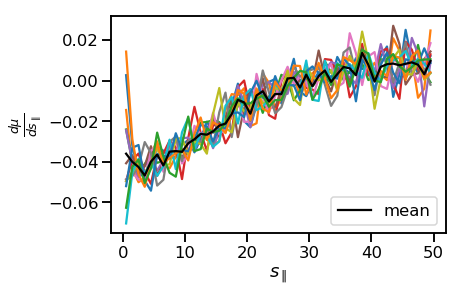

In [173]:
derivative_ind = []
sperp = 30
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1)
    m1_interp = UnivariateSpline(central_halos[0].r.r, 
                m1, s=0, k=2)#fill_value = (m1[0], m1[-1]),bounds_error = False)


    values = m1_interp.derivative(n=1)(central_halos[0].r.t)


    plt.plot(central_halos[0].r.t, derivative(m1_interp, central_halos[0].r.t))
    derivative_ind.append(values)

derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(central_halos[0].r.t,derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d \mu}{d s_\parallel}$')

Text(0, 0.5, '$\\frac{d ^2\\sigma}{d s_\\parallel^2}$')

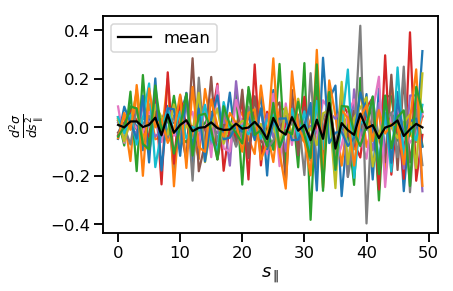

In [99]:
derivative_ind = []
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos**2, vlos, axis  = -1)
    m1_interp = interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False)


    plt.plot(derivative(m1_interp, central_halos[0].r.t, n=2))
    derivative_ind.append(derivative(m1_interp, central_halos[0].r.t, n=2))
    
derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d ^2\sigma}{d s_\parallel^2}$')

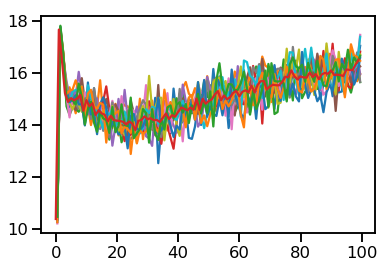

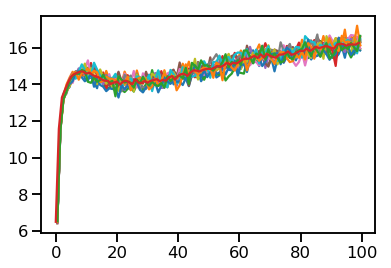

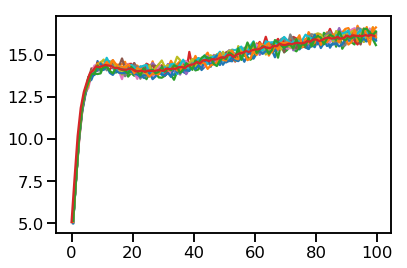

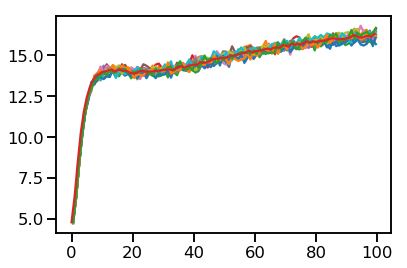

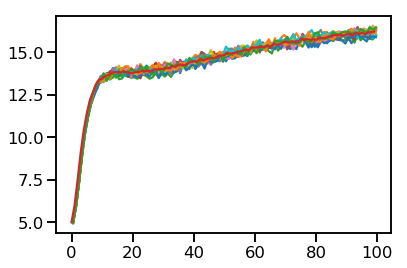

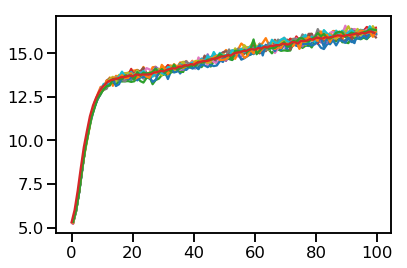

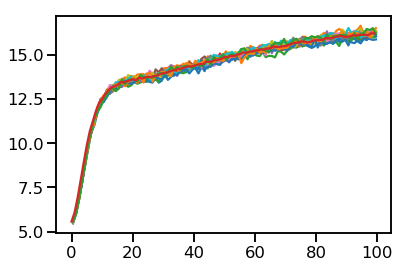

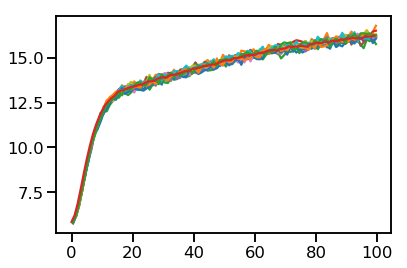

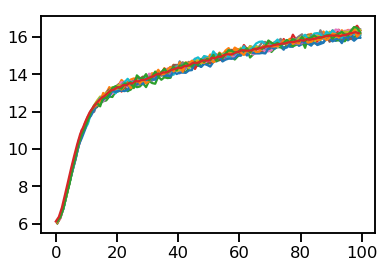

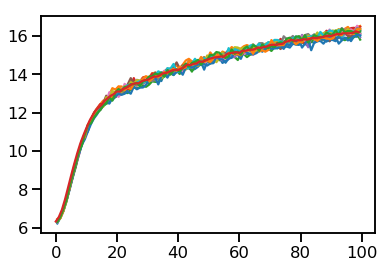

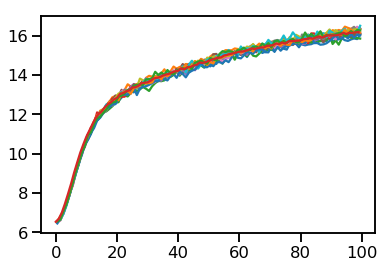

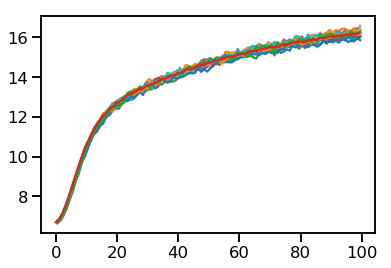

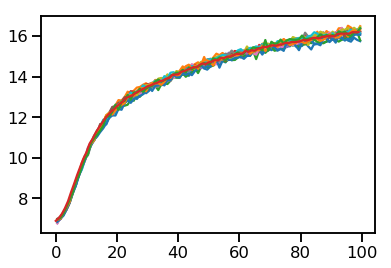

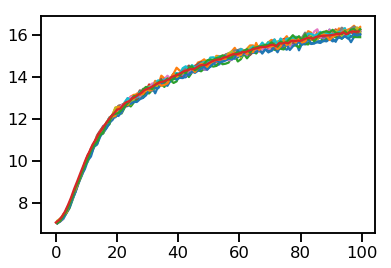

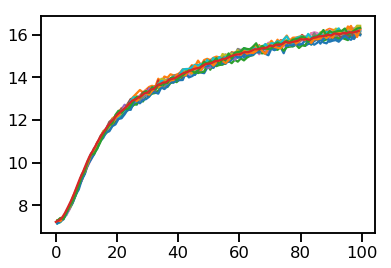

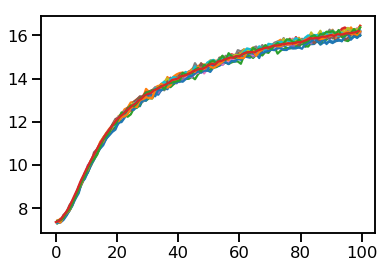

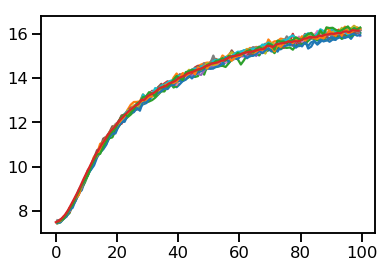

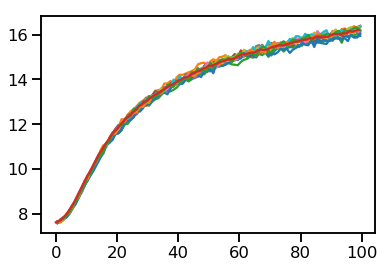

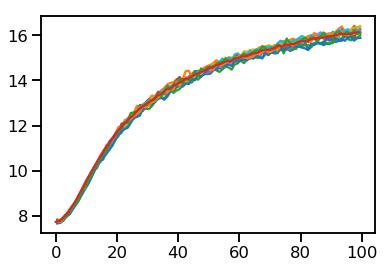

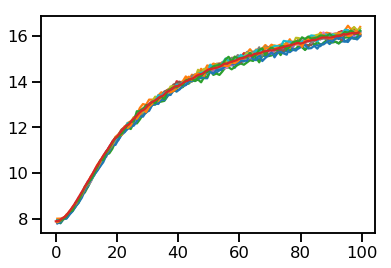

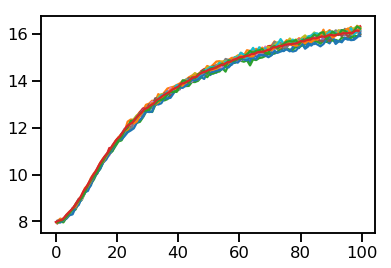

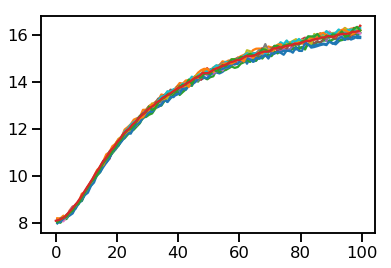

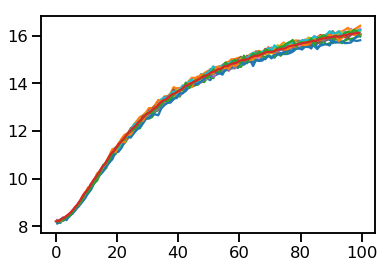

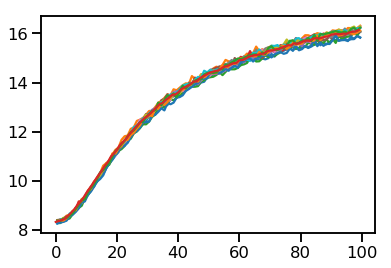

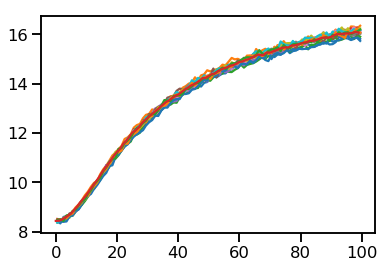

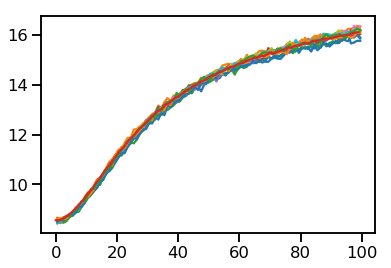

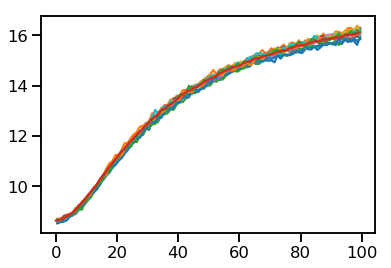

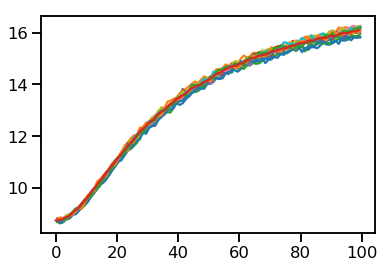

KeyboardInterrupt: 

In [148]:
approx = np.zeros((len(central_halos[0].r.t), len(central_halos[0].r.t)))
for i, rperp in enumerate(central_halos[0].r.t):
    m1_interp, m2_interp = [], []
    for box in range(len(central_halos)):
        m1 = simps(central_halos[box].jointpdf[i,:] * vlos, vlos, axis  = -1)
        m1_interp.append(interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False))

        m2 = simps(central_halos[box].jointpdf[i,:] * vlos**2, vlos, axis  = -1)
        m2_interp.append(interp1d(central_halos[0].r.r, m2, fill_value = (m2[0], m2[-1]),bounds_error = False))

    for m2_int in m2_interp:
        plt.plot(central_halos[0].r.r, m2_int(central_halos[0].r.r))

    plt.plot(np.mean([m2_int(central_halos[0].r.r) for m2_int in m2_interp], axis=0))
    plt.show()
    for j, rpar in enumerate(central_halos[0].r.t):
        #print(rpar)
        dm1_s, ddm2_s = [], []
        for box in range(len(central_halos)):
            dm1_s.append(derivative(m1_interp[box], rpar))
        
        
            ddm2_s.append(derivative(m2_interp[box], rpar, n=2))
        
        r = np.sqrt(rperp ** 2 + rpar**2)
        
        
        approx[i,j] =  interp_twopcf(r) - np.mean(dm1_s,axis=0) + 0.5 * np.mean(ddm2_s, axis = 0)
        
        
        

In [132]:
levels = np.arange(-4, 1, 0.3)


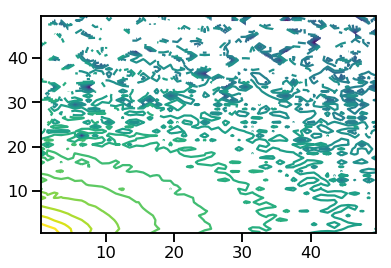

In [133]:
plt.contour(central_halos[0].r.t, central_halos[0].r.t ,np.log10(approx).T,
            levels = levels)

In [134]:
mu_c = 0.5 * (mu[1:] + mu[:-1])

In [140]:
pi_sigma_interpolation =interp2d(central_halos[0].r.t,
            central_halos[0].r.t, approx, kind='linear')

s_mu_approx = np.zeros_like(s_mu)

for i, s_value in enumerate(s_c):
    for j, mu_value in enumerate(mu_c):
        r_parallel = mu_value * s_value
        r_perpendicular = np.sqrt(s_value**2 - r_parallel**2)
        
        s_mu_approx[i,j] = pi_sigma_interpolation(r_parallel,
                                r_perpendicular)
        


In [141]:
        
monopole_approx = tpcf_multipole(s_mu_approx, mu, order = 0)
quadrupole_approx = tpcf_multipole(s_mu_approx, mu, order = 2)
hexadecapole_approx = tpcf_multipole(s_mu_approx, mu, order = 4)

## Compare multipoles

In [107]:
s_mu = real2red.integrate(rparallel, integrand)
monopole = tpcf_multipole(s_mu, mu, order = 0)
quadrupole = tpcf_multipole(s_mu, mu, order = 2)
hexadecapole = tpcf_multipole(s_mu, mu, order = 4)

In [37]:
bf_st_s_mu = real2red.integrate(rparallel, bf_st_integrand)
bf_st_monopole = tpcf_multipole(bf_st_s_mu, mu, order = 0)
bf_st_quadrupole = tpcf_multipole(bf_st_s_mu, mu, order = 2)
bf_st_hexadecapole = tpcf_multipole(bf_st_s_mu, mu, order = 4)

In [38]:
st_s_mu = real2red.integrate(rparallel, st_integrand)
st_monopole = tpcf_multipole(st_s_mu, mu, order = 0)
st_quadrupole = tpcf_multipole(st_s_mu, mu, order = 2)
st_hexadecapole = tpcf_multipole(st_s_mu, mu, order = 4)

In [39]:
bf_gaussian_s_mu = real2red.integrate(rparallel, bf_gaussian_integrand)
bf_gaussian_monopole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 0)
bf_gaussian_quadrupole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 2)
bf_gaussian_hexadecapole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 4)

In [40]:
gaussian_s_mu = real2red.integrate(rparallel, gaussian_integrand)
gaussian_monopole = tpcf_multipole(gaussian_s_mu, mu, order = 0)
gaussian_quadrupole = tpcf_multipole(gaussian_s_mu, mu, order = 2)
gaussian_hexadecapole = tpcf_multipole(gaussian_s_mu, mu, order = 4)

In [41]:
s_c = 0.5 * (s[1:] + s[:-1])

Text(0.5, 0, '$s$ [Mpc/h]')

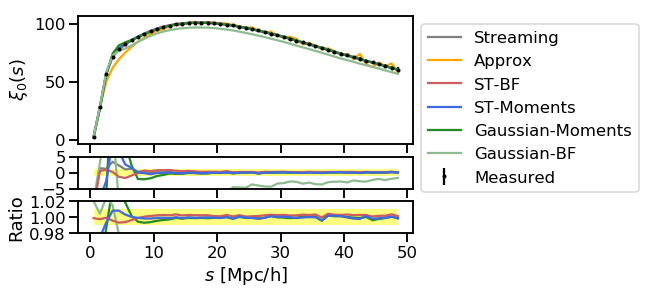

In [142]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1,1]})

ax1.errorbar(s_c, s_c*s_c*mean_mono,
            yerr = s_c * s_c * std_mono, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*monopole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*monopole_approx, color='orange', label='Approx')

ax1.plot(s_c, s_c*s_c*bf_st_monopole, color='indianred', label='ST-BF')
ax1.plot(s_c, s_c*s_c*st_monopole, color='royalblue', label='ST-Moments')
ax1.plot(s_c, s_c*s_c*gaussian_monopole, color='forestgreen', label='Gaussian-Moments')
ax1.plot(s_c, s_c*s_c*bf_gaussian_monopole, color='darkseagreen', label='Gaussian-BF')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_0(s)$')

ax2.plot(s_c, (monopole - mean_mono)/std_mono,
        color = 'gray')
ax2.plot(s_c, (gaussian_monopole - mean_mono)/std_mono,
        color = 'forestgreen')
ax2.plot(s_c, (bf_gaussian_monopole - mean_mono)/std_mono,
        color = 'darkseagreen')
ax2.plot(s_c, (bf_st_monopole - mean_mono)/std_mono,
        color = 'indianred')
ax2.plot(s_c, (st_monopole - mean_mono)/std_mono,
        color = 'royalblue')
ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)



ax3.plot(s_c, gaussian_monopole/monopole,
        color = 'forestgreen')
ax3.plot(s_c, bf_gaussian_monopole/monopole,
        color = 'darkseagreen')
ax3.plot(s_c, bf_st_monopole/monopole,
        color = 'indianred')
ax3.plot(s_c, st_monopole /monopole,
        color = 'royalblue')
ax3.fill_between(s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax3.set_ylim(0.98,1.02)

ax3.set_ylabel('Ratio')

ax3.set_xlabel(r'$s$ [Mpc/h]')

Text(0.5, 0, '$s$ [Mpc/h]')

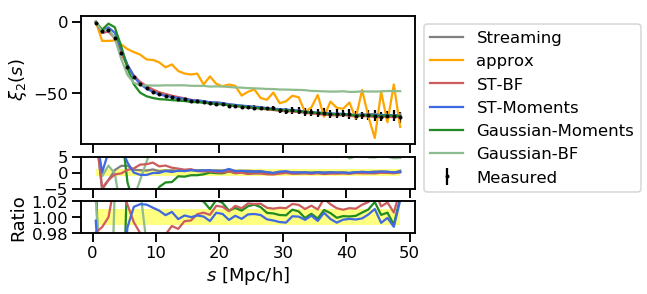

In [143]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1,1]})

ax1.errorbar(s_c, s_c*s_c*mean_quad,
            yerr = s_c * s_c * std_quad, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*quadrupole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*quadrupole_approx, color='orange', label='approx')

ax1.plot(s_c, s_c*s_c*bf_st_quadrupole, color='indianred', label='ST-BF')
ax1.plot(s_c, s_c*s_c*st_quadrupole, color='royalblue', label='ST-Moments')
ax1.plot(s_c, s_c*s_c*gaussian_quadrupole, color='forestgreen', label='Gaussian-Moments')
ax1.plot(s_c, s_c*s_c*bf_gaussian_quadrupole, color='darkseagreen', label='Gaussian-BF')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_2(s)$')

ax2.plot(s_c, (quadrupole - mean_quad)/std_quad,
        color = 'gray')
ax2.plot(s_c, (gaussian_quadrupole - mean_quad)/std_quad,
        color = 'forestgreen')
ax2.plot(s_c, (bf_gaussian_quadrupole - mean_quad)/std_quad,
        color = 'darkseagreen')
ax2.plot(s_c, (bf_st_quadrupole - mean_quad)/std_quad,
        color = 'indianred')
ax2.plot(s_c, (st_quadrupole - mean_quad)/std_quad,
        color = 'royalblue')
ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)



ax3.plot(s_c, gaussian_quadrupole/quadrupole,
        color = 'forestgreen')
ax3.plot(s_c, bf_gaussian_quadrupole/quadrupole,
        color = 'darkseagreen')
ax3.plot(s_c, bf_st_quadrupole/quadrupole,
        color = 'indianred')
ax3.plot(s_c, st_quadrupole /quadrupole,
        color = 'royalblue')
ax3.fill_between(s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax3.set_ylim(0.98,1.02)

ax3.set_ylabel('Ratio')

ax3.set_xlabel(r'$s$ [Mpc/h]')

Text(0.5, 0, '$s$ [Mpc/h]')

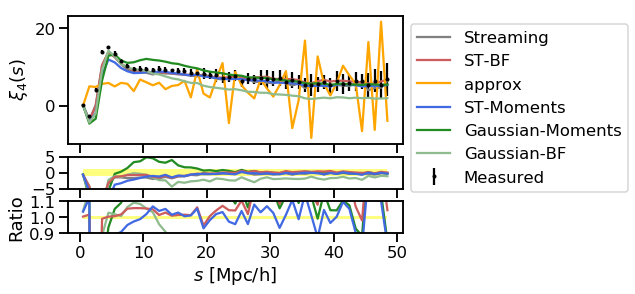

In [144]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1,1]})

ax1.errorbar(s_c, s_c*s_c*mean_hexa,
            yerr = s_c * s_c * std_hexa, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*hexadecapole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*bf_st_hexadecapole, color='indianred', label='ST-BF')
ax1.plot(s_c, s_c*s_c*hexadecapole_approx, color='orange', label='approx')

ax1.plot(s_c, s_c*s_c*st_hexadecapole, color='royalblue', label='ST-Moments')
ax1.plot(s_c, s_c*s_c*gaussian_hexadecapole, color='forestgreen', label='Gaussian-Moments')
ax1.plot(s_c, s_c*s_c*bf_gaussian_hexadecapole, color='darkseagreen', label='Gaussian-BF')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_4(s)$')

ax2.plot(s_c, (hexadecapole - mean_hexa)/std_hexa,
        color = 'gray')
ax2.plot(s_c, (gaussian_hexadecapole - mean_hexa)/std_hexa,
        color = 'forestgreen')
ax2.plot(s_c, (bf_gaussian_hexadecapole - mean_hexa)/std_hexa,
        color = 'darkseagreen')
ax2.plot(s_c, (bf_st_hexadecapole - mean_hexa)/std_hexa,
        color = 'indianred')
ax2.plot(s_c, (st_hexadecapole - mean_hexa)/std_hexa,
        color = 'royalblue')
ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)



ax3.plot(s_c, gaussian_hexadecapole/hexadecapole,
        color = 'forestgreen')
ax3.plot(s_c, bf_gaussian_hexadecapole/hexadecapole,
        color = 'darkseagreen')
ax3.plot(s_c, bf_st_hexadecapole/hexadecapole,
        color = 'indianred')
ax3.plot(s_c, st_hexadecapole /hexadecapole,
        color = 'royalblue')
ax3.fill_between(s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax3.set_ylim(0.9,1.1)

ax3.set_ylabel('Ratio')

ax3.set_xlabel(r'$s$ [Mpc/h]')